In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pyatera/Pyaterochka_transactions_.csv
/kaggle/input/raifha/client_cat_raif.csv
/kaggle/input/raifha/clients_last_2_fixed.csv


In [2]:
data = pd.read_csv('../input/pyatera/Pyaterochka_transactions_.csv', encoding = 'cp1251', sep=';', parse_dates=['purchdate'])

In [3]:
client_cats = pd.read_csv('../input/raifha/client_cat_raif.csv', encoding = 'cp1251', sep=';')

In [4]:
clients = pd.read_csv('../input/raifha/clients_last_2_fixed.csv', encoding = 'cp1251', sep=';')
clients = clients.rename(columns={"categorycode":"category", "cnum_":"cnum"}).copy()

Сводим в одну таблицу

In [5]:
clients = pd.merge(clients, client_cats, how='inner', on = "category")

In [6]:
data1 = pd.merge(clients, data, how='inner', on = 'cnum')

# Feature Engineering

In [7]:
# фичи можно добавить только с purchdate и amount
# purchdate -> days_since_first_order(recency), days_since_last_order, frequency
# amount -> overall_amount(Monetary), order_sum, avg_amount_in_3_last_trans
# 
# мы можем прогнозозировать не только отток, но и уход к конкуренту
# 
# for i in data1.cnum.unique():
    

К каждой строке добавим дату первого заказа для каждого клиента

In [8]:
data1 = pd.merge(data1, data1.sort_values(['purchdate']).groupby('cnum').head(1).loc[:, ["purchdate", 'cnum']].rename(columns={"purchdate":"first_trans"}), on='cnum',
         how='left')

# Recency

In [9]:
data1['days_since_first_order'] = (data1.purchdate - data1.first_trans)

In [10]:
tmp = data1.drop_duplicates(subset=['cnum','purchdate']).sort_values(['purchdate'])[['cnum', 'purchdate', 'amount']]

In [11]:
tmp['days_since_last_order']  = tmp.groupby('cnum')['purchdate'].diff().apply(lambda x: x.days)

In [12]:
tmp = tmp[['cnum', 'purchdate', 'days_since_last_order']]

In [13]:
tmp.dropna(subset=['days_since_last_order'], inplace=True)

In [14]:
tmp['order_sum'] = 1
tmp.order_sum = tmp.groupby(['cnum']).order_sum.cumsum()

In [15]:
df = pd.merge(data1, 
         tmp,
         on=['cnum','purchdate'],
         how='left'
)


проверка таргета

In [16]:
df[df.cnum == 'EEPLLD'].sort_values("purchdate").head(50)

,cnum,category,gender,age,married_,residenttype,description,purchdate,amount,mcc,mrchcity,mrchname,first_trans,days_since_first_order,days_since_last_order,order_sum
569268,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-09-16,129.98,5411,EKATERINBURG,WO7E1JXIA37,2019-09-16,0 days,NaN,NaN
569493,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-09-18,19.98,5411,EKATERINBURG,WO7E1JXIA37 5GBQ,2019-09-16,2 days,2.0,1.0
569349,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-09-18,57.16,5411,EKATERINBURG,WO7E1JXIA37 M6G56,2019-09-16,2 days,2.0,1.0
569473,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-09-18,29.53,5411,EKATERINBURG,WO7E1JXIA37 SMBV,2019-09-16,2 days,2.0,1.0
569309,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-09-18,67.18,5411,EKATERINBURG,WO7E1JXIA37 GV6S,2019-09-16,2 days,2.0,1.0
569429,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-09-18,37.18,5411,EKATERINBURG,WO7E1JXIA37 SMMV,2019-09-16,2 days,2.0,1.0
569300,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-09-18,73.98,5411,EKATERINBURG,WO7E1JXIA37 F6PF,2019-09-16,2 days,2.0,1.0
569248,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-09-19,318.96,5411,EKATERINBURG,WO7E1JXIA37 M6G56,2019-09-16,3 days,1.0,2.0
569443,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-09-20,34.97,5411,PERVOURALSK,WO7E1JXIA37,2019-09-16,4 days,1.0,3.0
569351,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-09-20,55.98,5411,EKATERINBURG,WO7E1JXIA37 FSGM,2019-09-16,4 days,1.0,3.0


Модель оттока

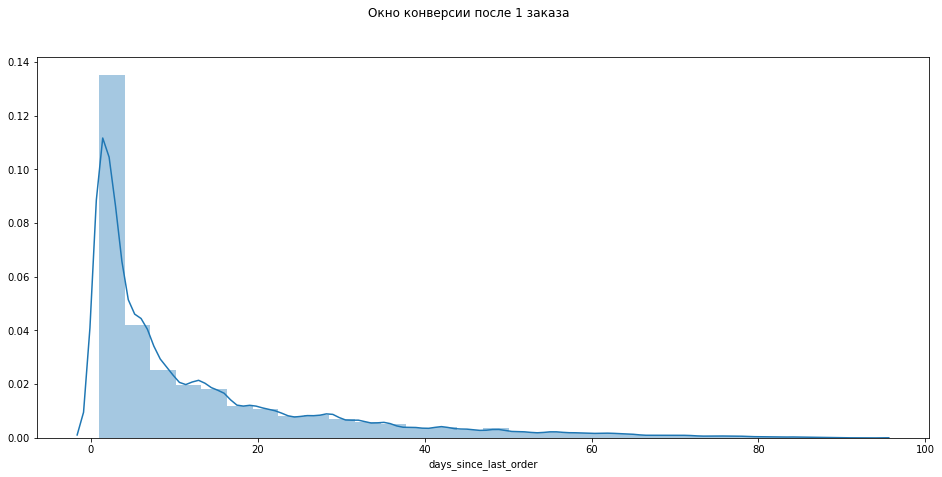

In [17]:
f, ax = plt.subplots(1, figsize=(16, 7))
f.suptitle('Окно конверсии после 1 заказа')
sns.distplot(df.query("order_sum == 1").days_since_last_order, bins=30, ax=ax)

In [18]:
np.percentile(df.query("order_sum == 1").days_since_last_order, 95)

48.0

Будем считать, что если клиент не делает второй заказ уже 48 дней, то он скорее всего его и не сделает.

In [19]:
np.percentile(df.query("order_sum > 1").days_since_last_order, 95)

20.0

Если у человека уже не первый заказ, то в худшем случае окно конверсии 20 дней. Будем считать, что клиент ушёл, если он не делает заказ уже 20 дней. Удаляю пользователей, которые появились в бд в первые 20 дней. (Потому что считать заказы в этот период "новыми" неправильно. Будет смещение)

In [20]:
valid_users = df[df.first_trans > df.purchdate.min() + pd.DateOffset(20)].cnum.unique()

In [21]:
clients_one_order = df.groupby('cnum').days_since_first_order.max().reset_index().cnum.unique()

In [22]:
df['target_one_order'] = df.loc[df.cnum.isin(clients_one_order), 'target_one_order'] = 1


In [23]:
df.target_one_order = df.target_one_order.fillna(0)

In [24]:
len(df.cnum.unique())

574667

In [25]:
# Клиенты, которые не делают заказ больше 88 дней на максимальную дату из бд не вернутся. (см EDA 2 ниже)
old_clients = (((df.purchdate.max() - df.groupby('cnum').purchdate.max()) / np.timedelta64(1, 'D')).reset_index().query("purchdate > 20")).cnum.unique()

In [26]:
len(old_clients)

277777

In [27]:
#Таргет последних трёх заказов клиента
df.loc[df[df.cnum.isin(old_clients)].groupby('cnum').tail(3).index, 'target_last_3_orders'] = 1

#Таргет последних двух заказов клиента
df.loc[df[df.cnum.isin(old_clients)].groupby('cnum').tail(2).index, 'target_last_2_orders'] = 1

#Таргет последнего заказа клиента
df.loc[df[df.cnum.isin(old_clients)].groupby('cnum').tail(1).index, 'target_last_1_orders'] = 1

In [28]:
df.fillna(value = {'target_last_3_orders': 0, 'target_last_2_orders':0,
       'target_last_1_orders':0 },  inplace=True)

In [29]:
df['days_since_first_order'] = df['days_since_first_order'] / np.timedelta64(1, 'D')

In [44]:
df

,cnum,category,gender,age,married_,residenttype,description,purchdate,amount,mcc,mrchcity,mrchname,first_trans,days_since_first_order,days_since_last_order,order_sum,target_one_order,target_last_3_orders,target_last_2_orders,target_last_1_orders
0,0CCCOD,81,M,36,not_married,R,Affluent Banking payroll customer,2019-10-29,3551.13,5411,MOSCOW,WO7E1JXIA37,2019-10-07,22.0,6.0,4.0,1,0.0,0.0,0.0
1,0CCCOD,81,M,36,not_married,R,Affluent Banking payroll customer,2019-11-20,3441.89,5411,MOSCOW,WO7E1JXIA37,2019-10-07,44.0,8.0,8.0,1,0.0,0.0,0.0
2,0CCCOD,81,M,36,not_married,R,Affluent Banking payroll customer,2019-12-08,3214.62,5411,MOSCOW,WO7E1JXIA37,2019-10-07,62.0,5.0,12.0,1,0.0,0.0,0.0
3,0CCCOD,81,M,36,not_married,R,Affluent Banking payroll customer,2019-11-05,3081.34,5411,MOSCOW,WO7E1JXIA37,2019-10-07,29.0,7.0,5.0,1,0.0,0.0,0.0
4,0CCCOD,81,M,36,not_married,R,Affluent Banking payroll customer,2019-11-25,2877.71,5411,MOSCOW,WO7E1JXIA37,2019-10-07,49.0,5.0,9.0,1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4479922,JTLRQT,51,M,53,married,R,Corporate customer employee/ payroll scheme (f...,2019-09-21,1123.58,5411,SANKT-PETERBU,WO7E1JXIA37 BV,2019-09-16,5.0,5.0,1.0,1,0.0,0.0,0.0
4479923,JTLRQT,51,M,53,married,R,Corporate customer employee/ payroll scheme (f...,2019-09-21,830.96,5411,SANKT-PETERBU,WO7E1JXIA37 M5,2019-09-16,5.0,5.0,1.0,1,0.0,0.0,0.0
4479924,JTLRQT,51,M,53,married,R,Corporate customer employee/ payroll scheme (f...,2019-09-24,714.76,5411,SANKT-PETERBU,WO7E1JXIA37 MFG,2019-09-16,8.0,3.0,2.0,1,1.0,0.0,0.0
4479925,JTLRQT,51,M,53,married,R,Corporate customer employee/ payroll scheme (f...,2019-09-29,437.49,5411,SANKT-PETERBU,WO7E1JXIA37 M5,2019-09-16,13.0,1.0,5.0,1,1.0,1.0,0.0


Откидываю последние 48 дней, потому что окно конверсии в случае не первого заказа 48 дней

In [75]:
data = df[(df.cnum.isin(valid_users)) & (df.purchdate < df.purchdate.max() - pd.DateOffset(38))]

In [76]:
data.target_last_3_orders.value_counts()

0.0    334407
1.0    205134
Name: target_last_3_orders, dtype: int64

In [34]:
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score

# Разберемся с категориальными признаками
cnum, gender, married_, residenttype, description, purchdate, mrchcity, mrchname, first_trans

In [77]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
data['gender'] = lbl.fit_transform(data['gender'].astype(str))
data['age'] = lbl.fit_transform(data['age'].astype(str))
data['mrchcity'] = lbl.fit_transform(data['mrchcity'].astype(str))
data['married_'] = lbl.fit_transform(data['married_'].astype(str))
data['cnum_uncut'] = lbl.fit_transform(data['cnum'].astype(str))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [78]:
data

,cnum,category,gender,age,married_,residenttype,description,purchdate,amount,mcc,...,mrchname,first_trans,days_since_first_order,days_since_last_order,order_sum,target_one_order,target_last_3_orders,target_last_2_orders,target_last_1_orders,cnum_uncut
0,0CCCOD,81,1,21,1,R,Affluent Banking payroll customer,2019-10-29,3551.13,5411,...,WO7E1JXIA37,2019-10-07,22.0,6.0,4.0,1,0.0,0.0,0.0,3
3,0CCCOD,81,1,21,1,R,Affluent Banking payroll customer,2019-11-05,3081.34,5411,...,WO7E1JXIA37,2019-10-07,29.0,7.0,5.0,1,0.0,0.0,0.0,3
9,0CCCOD,81,1,21,1,R,Affluent Banking payroll customer,2019-10-16,2285.55,5411,...,WO7E1JXIA37,2019-10-07,9.0,9.0,1.0,1,0.0,0.0,0.0,3
10,0CCCOD,81,1,21,1,R,Affluent Banking payroll customer,2019-10-07,2264.85,5411,...,WO7E1JXIA37,2019-10-07,0.0,NaN,NaN,1,0.0,0.0,0.0,3
11,0CCCOD,81,1,21,1,R,Affluent Banking payroll customer,2019-10-23,2248.56,5411,...,WO7E1JXIA37,2019-10-07,16.0,3.0,3.0,1,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4479903,MFONDN,61,0,46,1,R,RBA employees (family),2019-10-14,37.99,5411,...,WO7E1JXIA37,2019-10-14,0.0,NaN,NaN,1,1.0,1.0,1.0,185217
4479904,0YXYHF,30,1,16,1,R,Corporate customer manager/ VIP,2019-10-24,284.92,5411,...,WO7E1JXIA37 MFM5G,2019-10-24,0.0,NaN,NaN,1,1.0,1.0,1.0,2769
4479910,JRKMIR,30,1,52,0,R,Corporate customer manager/ VIP,2019-11-08,334.96,5411,...,WO7E1JXIA37 MV5P,2019-11-02,6.0,1.0,2.0,1,0.0,0.0,0.0,174677
4479911,JRKMIR,30,1,52,0,R,Corporate customer manager/ VIP,2019-11-07,208.96,5411,...,WO7E1JXIA37 MMPPP,2019-11-02,5.0,5.0,1.0,1,1.0,0.0,0.0,174677


In [79]:
cols_target = ['category', 'gender', 'age', 'married_', 'amount', 'mrchcity','target_last_3_orders', 'days_since_first_order', 'order_sum']

In [80]:
data = data[cols_target]

In [82]:
X, y = data.drop('target_last_3_orders', axis=1), data.target_last_3_orders

In [89]:
X_train, y_train = X[:400000], y[:400000]
X_test, y_test = X[400000:], y[400000:]


In [84]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [87]:
def get_metrics(actual, predicted, prob):
  print(f"Precision: {precision_score(actual, predicted)}")
  print(f"Recall: {recall_score(actual, predicted)}")
  print(f"F1: {f1_score(actual, predicted)}")
  print(f"AUC-ROC: {roc_auc_score(actual, prob)}")

In [92]:
get_metrics(y_test, xgb.predict(X_test), xgb.predict_proba(X_test)[:,1])

Precision: 0.5554137042988267
Recall: 0.5074509803921569
F1: 0.5303501618395056
AUC-ROC: 0.737802682053333


In [93]:
!pip install shap

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [94]:
import shap

In [99]:
xgb = XGBClassifier(random_state=42)
mymodel = xgb.fit(X_train, y_train)
mybooster = mymodel.get_booster()    
model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

# Shap explainer initilization
shap_ex = shap.TreeExplainer(mybooster)

In [102]:
shap_values = shap_ex.shap_values(X_test)

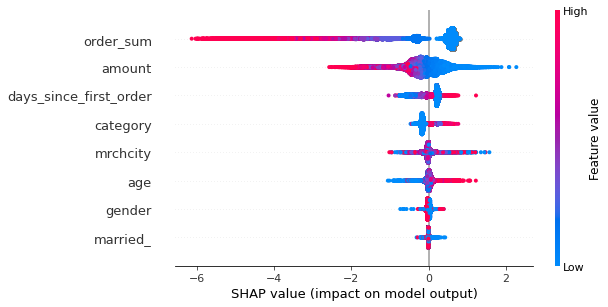

In [104]:
shap.summary_plot(shap_values, X_test)

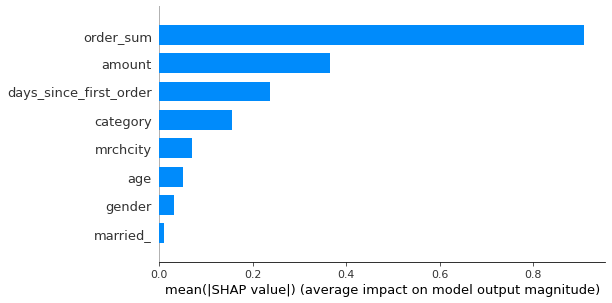

In [105]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

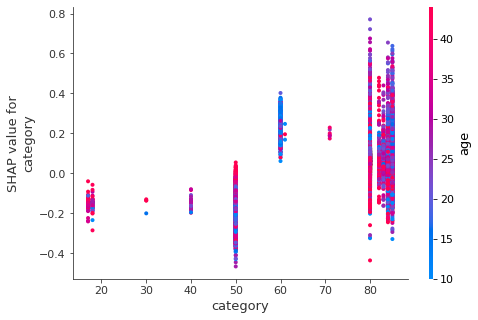

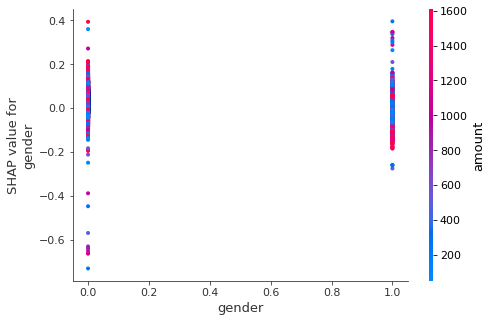

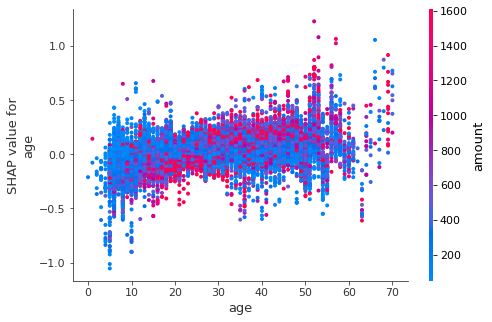

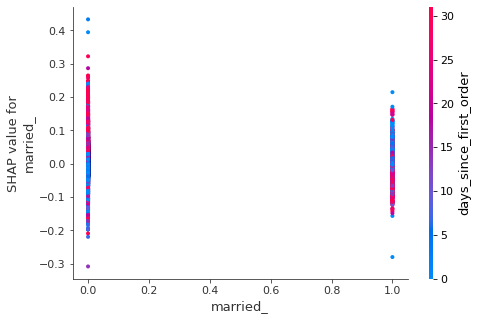

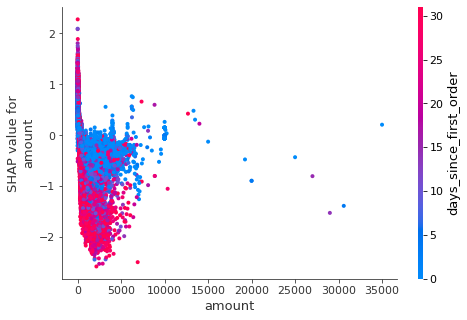

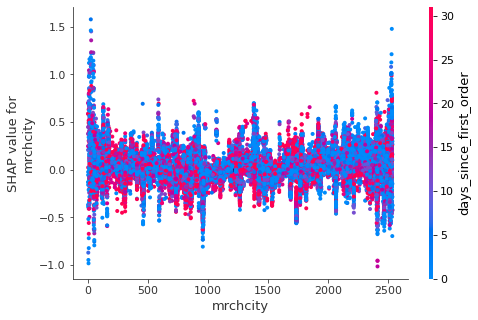

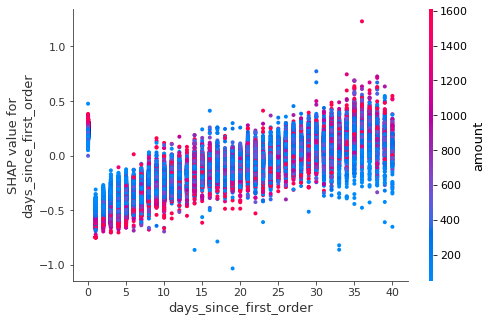

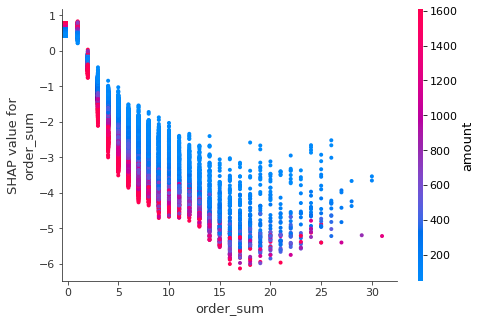

In [109]:
for col in X_test.columns:
  shap.dependence_plot(col, shap_values, X_test)